Проверяем версию Python

In [1]:
import sys
print(sys.version)

3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]


Импортируем pandas и выводим на экран наши данные

In [2]:
import pandas as pd

df = pd.read_csv('data.csv')
df['order_date'] = df['order_date'].astype('datetime64[ns]')
df

,client_id,order_date,order_price,city_id
0,43017,2022-01-01,10000,1
1,43022,2022-01-01,7700,3
2,43104,2022-01-01,3200,1
3,43116,2022-01-01,9700,1
4,43153,2022-01-01,6750,2
...,...,...,...,...
10921,52725,2022-10-31,6500,1
10922,52769,2022-10-31,6550,3
10923,52813,2022-10-31,4650,2
10924,52879,2022-10-31,1800,2


Для того, чтобы рассчитать классический retention, который рассчитывается как отношение количества уникальных пользователей, взаимодействующих с продуктом в день N, к количеству уникальных пользователей, воспользовавшихся продуктом N дней назад, необходимо установить дату (день) начала взаимодействия пользователя с продуктом, т.е. он показывает процент пользователей, вернувшихся N дней спустя.

In [3]:
start_date = df.groupby('client_id')['order_date'].min()
start_date = start_date.rename('start_date')
start_date.head()

client_id
43000   2022-01-08
43001   2022-01-14
43002   2022-01-03
43003   2022-01-14
43004   2022-01-26
Name: start_date, dtype: datetime64[ns]

Присоединим start_date к изначальной таблице

In [4]:
df = pd.merge(df, start_date, left_on='client_id', right_index=True)
df

,client_id,order_date,order_price,city_id,start_date
0,43017,2022-01-01,10000,1,2022-01-01
1,43022,2022-01-01,7700,3,2022-01-01
2,43104,2022-01-01,3200,1,2022-01-01
1019,43104,2022-01-30,3550,1,2022-01-01
3,43116,2022-01-01,9700,1,2022-01-01
...,...,...,...,...,...
10921,52725,2022-10-31,6500,1,2022-10-31
10922,52769,2022-10-31,6550,3,2022-10-31
10923,52813,2022-10-31,4650,2,2022-10-31
10924,52879,2022-10-31,1800,2,2022-10-31


Вычислим, сколько дней прошло с момента первого взаимодействия пользователя до текущего взаимодействия

In [5]:
df['days_since_start'] = (df['order_date']-df['start_date'])
df

,client_id,order_date,order_price,city_id,start_date,days_since_start
0,43017,2022-01-01,10000,1,2022-01-01,0 days
1,43022,2022-01-01,7700,3,2022-01-01,0 days
2,43104,2022-01-01,3200,1,2022-01-01,0 days
1019,43104,2022-01-30,3550,1,2022-01-01,29 days
3,43116,2022-01-01,9700,1,2022-01-01,0 days
...,...,...,...,...,...,...
10921,52725,2022-10-31,6500,1,2022-10-31,0 days
10922,52769,2022-10-31,6550,3,2022-10-31,0 days
10923,52813,2022-10-31,4650,2,2022-10-31,0 days
10924,52879,2022-10-31,1800,2,2022-10-31,0 days


Тоже самое сделаем для недель и месяцев

In [6]:
import numpy as np

df['start_week'] = df.apply(lambda x: (x['start_date'] - pd.Timedelta(x['start_date'].dayofweek, u='day')).date(), axis=1)
df['start_week'] = pd.to_datetime(df['start_week'])
df['weeks_since_start'] = np.floor((df['order_date'] - df['start_week']) / np.timedelta64(1, 'W'))

df

,client_id,order_date,order_price,city_id,start_date,days_since_start,start_week,weeks_since_start
0,43017,2022-01-01,10000,1,2022-01-01,0 days,2021-12-31,0.0
1,43022,2022-01-01,7700,3,2022-01-01,0 days,2021-12-31,0.0
2,43104,2022-01-01,3200,1,2022-01-01,0 days,2021-12-31,0.0
1019,43104,2022-01-30,3550,1,2022-01-01,29 days,2021-12-31,4.0
3,43116,2022-01-01,9700,1,2022-01-01,0 days,2021-12-31,0.0
...,...,...,...,...,...,...,...,...
10921,52725,2022-10-31,6500,1,2022-10-31,0 days,2022-10-31,0.0
10922,52769,2022-10-31,6550,3,2022-10-31,0 days,2022-10-31,0.0
10923,52813,2022-10-31,4650,2,2022-10-31,0 days,2022-10-31,0.0
10924,52879,2022-10-31,1800,2,2022-10-31,0 days,2022-10-31,0.0


In [7]:
df['start_month'] = df['start_date'].values.astype('datetime64[M]')
df['months_since_start'] = np.floor((df['order_date'] - df['start_month']) / np.timedelta64(1, 'M'))

df

,client_id,order_date,order_price,city_id,start_date,days_since_start,start_week,weeks_since_start,start_month,months_since_start
0,43017,2022-01-01,10000,1,2022-01-01,0 days,2021-12-31,0.0,2022-01-01,0.0
1,43022,2022-01-01,7700,3,2022-01-01,0 days,2021-12-31,0.0,2022-01-01,0.0
2,43104,2022-01-01,3200,1,2022-01-01,0 days,2021-12-31,0.0,2022-01-01,0.0
1019,43104,2022-01-30,3550,1,2022-01-01,29 days,2021-12-31,4.0,2022-01-01,0.0
3,43116,2022-01-01,9700,1,2022-01-01,0 days,2021-12-31,0.0,2022-01-01,0.0
...,...,...,...,...,...,...,...,...,...,...
10921,52725,2022-10-31,6500,1,2022-10-31,0 days,2022-10-31,0.0,2022-10-01,0.0
10922,52769,2022-10-31,6550,3,2022-10-31,0 days,2022-10-31,0.0,2022-10-01,0.0
10923,52813,2022-10-31,4650,2,2022-10-31,0 days,2022-10-31,0.0,2022-10-01,0.0
10924,52879,2022-10-31,1800,2,2022-10-31,0 days,2022-10-31,0.0,2022-10-01,0.0


Рассчитаем классический ретеншн

In [8]:
import matplotlib.pyplot as plt

whole_retention = df.groupby('days_since_start', as_index=False)['client_id'].nunique()
whole_retention['client_id'] = whole_retention['client_id'] / df['client_id'].nunique() * 100
whole_retention['days_since_start'] /= np.timedelta64(1, 'D')
whole_retention

,days_since_start,client_id
0,0.0,100.000000
1,3.0,0.717087
2,4.0,0.817927
3,5.0,0.750700
4,6.0,0.661064
...,...,...
82,85.0,0.011204
83,86.0,0.011204
84,87.0,0.022409
85,88.0,0.011204


И построим график зависимости процента оставшихся пользователей от дня, прошедшего с момента первого взаимодействия

Text(0, 0.5, 'Percent Of Users Retained')

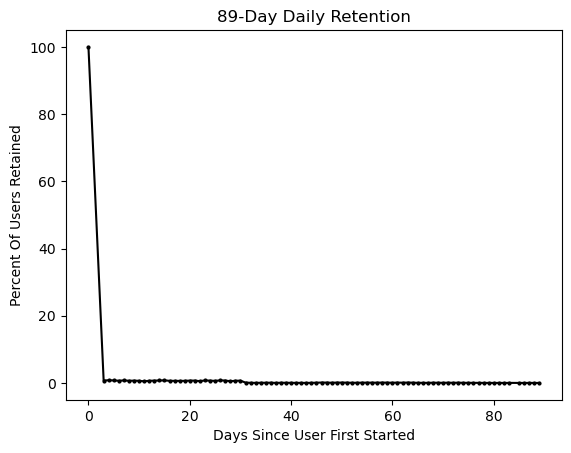

In [9]:
plt.plot(whole_retention['days_since_start'], whole_retention['client_id'], marker='o', markersize=2, color='black')
plt.title(f"{int(whole_retention['days_since_start'].max())}-Day Daily Retention")
plt.xlabel("Days Since User First Started")
plt.ylabel("Percent Of Users Retained")

Видим, что
- Процент вернувшихся пользователей падает почти сразу
- В случае классического ретеншна нет смысла рассчитывать такой большой интервал

Поэтому, ограничим интервал, например, 5-ю днями

Text(0, 0.5, 'Percent Of Users Retained')

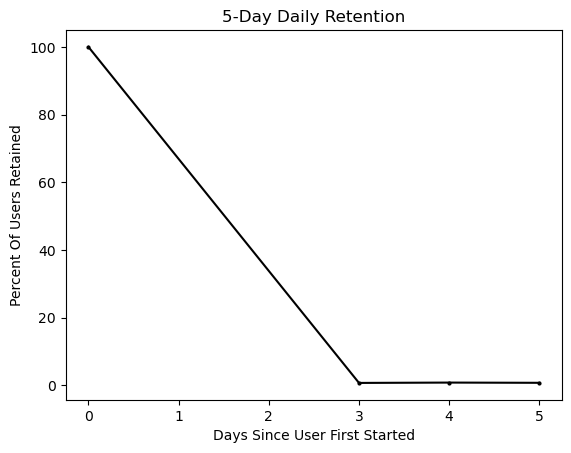

In [10]:
whole_retention_from_N = lambda whole_retention, N: whole_retention[(whole_retention['days_since_start'] <= N)]
N = 5

plt.plot(whole_retention_from_N(whole_retention, N)['days_since_start'], 
         whole_retention_from_N(whole_retention, N)['client_id'], 
         marker='o', markersize=2, color='black')
plt.title(f"{N}-Day Daily Retention")
plt.xlabel("Days Since User First Started")
plt.ylabel("Percent Of Users Retained")

Отсюда, заметим, что к 3-ему дню почти не остается вернувшихся пользователей. Однако, стоит отметить, что у нас нет данных на первый и второй дни, поэтому может оказаться, что вернувшихся пользователей не остается уже и на первый день.

Результаты являются такими, так как пользователи не взаимодействую с продуктом каждый день (а именно, не заказывают домашний ремонт ежедневно). 

Другой метрикой, говорящей о жизнеспособности продукта, является возвратный ретеншн. В отличие от классического, в нем мы считаем количество людей, воспользовавшихся продуктом хотя бы 1 день в течение определенного периода. Проще всего в качестве периодов брать недели и месяца, поэтому мы и рассчитывали их ранее.

Построим зависимости для недельного и месячного ретеншнов.

Text(0, 0.5, 'Percent Of Users Retained')

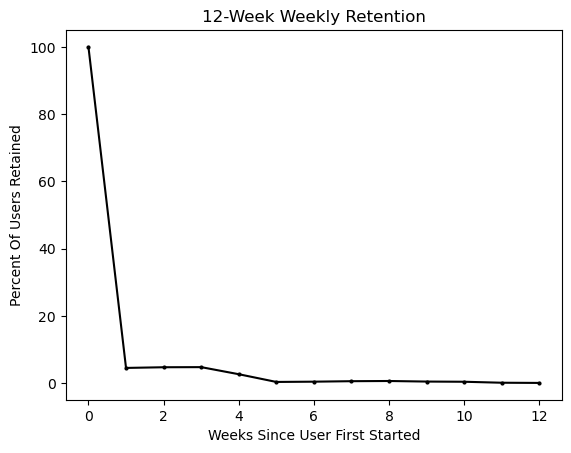

In [11]:
whole_retention_weeks = df.groupby('weeks_since_start', as_index=False)['client_id'].nunique()
whole_retention_weeks['client_id'] = whole_retention_weeks['client_id'] / df['client_id'].nunique() * 100

plt.plot(whole_retention_weeks['weeks_since_start'], 
         whole_retention_weeks['client_id'], 
         marker='o', markersize=2, color='black')
plt.title(f"{int(whole_retention_weeks['weeks_since_start'].max())}-Week Weekly Retention")
plt.xlabel("Weeks Since User First Started")
plt.ylabel("Percent Of Users Retained")

Text(0, 0.5, 'Percent Of Users Retained')

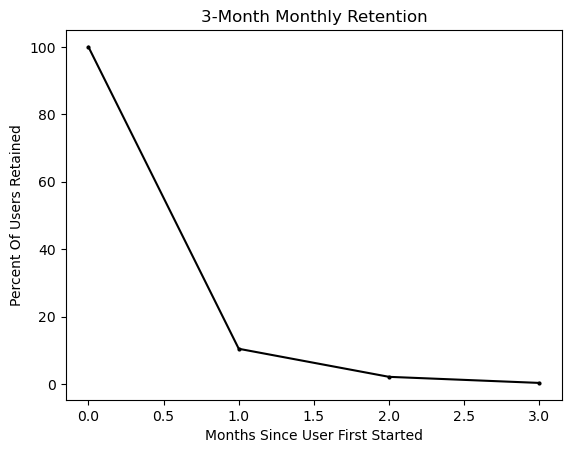

In [12]:
whole_retention_months = df.groupby('months_since_start', as_index=False)['client_id'].nunique()
whole_retention_months['client_id'] = whole_retention_months['client_id'] / df['client_id'].nunique() * 100

plt.plot(whole_retention_months['months_since_start'], whole_retention_months['client_id'], 
         marker='o', markersize=2, color='black')
plt.title(f"{int(whole_retention_months['months_since_start'].max())}-Month Monthly Retention")
plt.xlabel("Months Since User First Started")
plt.ylabel("Percent Of Users Retained")

Сравним их с дневным ретеншном

Text(0, 0.5, 'Percent Of Users Retained')

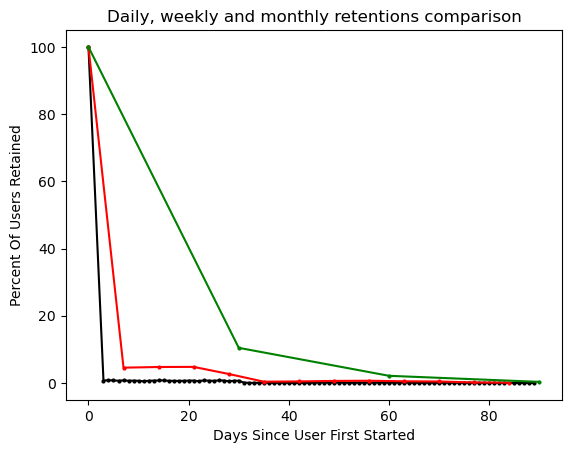

In [13]:
plt.plot(whole_retention['days_since_start'], 
         whole_retention['client_id'], 
         marker='o', markersize=2, color='black')

plt.plot(whole_retention_weeks['weeks_since_start']*7, 
         whole_retention_weeks['client_id'], 
         marker='o', markersize=2, color='red')

plt.plot(whole_retention_months['months_since_start']*30, 
         whole_retention_months['client_id'], 
         marker='o', markersize=2, color='green')

plt.title(f"Daily, weekly and monthly retentions comparison")
plt.xlabel("Days Since User First Started")
plt.ylabel("Percent Of Users Retained")

Как и ожидалось, недельный и месячный ретеншны ложатся выше дневного, причем видно, что даже спустя месяц некоторые пользователи возвращаются.

Такой график может говорить о том, что либо вернувшийся человек сейчас активно проводит ремонтные работы, либо ему не понравился сервис, и он хочет воспользоваться определенной гарантией.

Далее, можно построить и повторяющийся ретеншн, учитывающий возврат пользователя и после N-го дня.

In [14]:
df_dayint = df
df_dayint['days_since_start'] /= np.timedelta64(1, 'D')

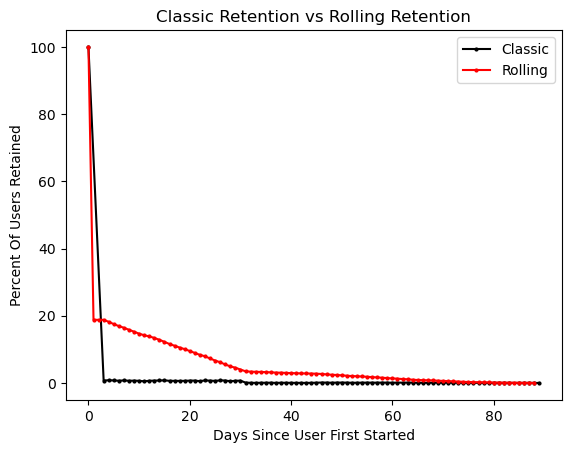

In [15]:
rolling_retention = lambda df_dayint, N: (df_dayint[(df_dayint['days_since_start'] >= N)]['client_id'].nunique() 
                                          / df['client_id'].nunique() * 100)

cutoff = 89
rolling_retention_arr = np.zeros(cutoff)
for i in range(cutoff):
    rolling_retention_arr[i] = rolling_retention(df_dayint, i)

plt.plot(whole_retention['days_since_start'], whole_retention['client_id'], 
         marker='o', markersize=2, color='black', label='Classic')
plt.plot(np.linspace(0, cutoff-1, cutoff), rolling_retention_arr,
         marker='o', markersize=2, color='red', label='Rolling')
plt.title(f"Classic Retention vs Rolling Retention")
plt.xlabel("Days Since User First Started")
plt.ylabel("Percent Of Users Retained")
plt.legend(loc="best")

Видим, что повторяющийся ретеншн сигнализирует нам о гораздо большем числе возвращающихся пользователей, чем классических ретеншн. 

Это говорит о том, что люди могут вернуться как спустя день, так и спустя месяцы, но спустя месяцы они будут возвращаться гораздо реже.

Таким образом, понимаем, что сервисом пользуются люди, в основном, единоразово, что естественно в области ремонтных работ.

При этом можно сравнить классический ретеншн для каждого города

In [16]:
df_by_city = lambda df, city_id: df[(df['city_id'] == city_id)]

In [17]:
def whole_retention_by_city(df, city_id):
    retention = df_by_city(df, city_id).groupby('days_since_start', as_index=False)['client_id'].nunique()
    retention['client_id'] = retention['client_id'] / df_by_city(df, city_id)['client_id'].nunique() * 100
    
    return retention

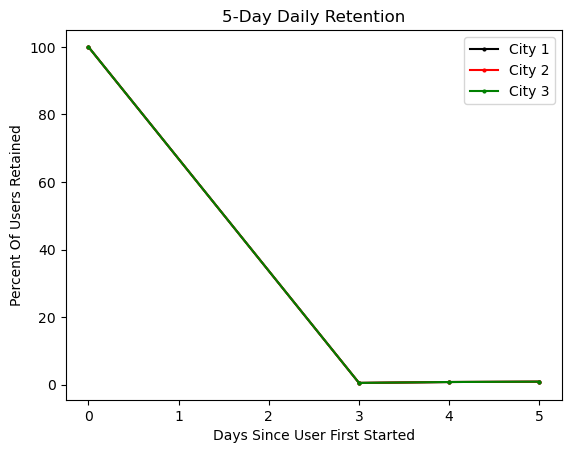

In [18]:
N = 5
whole_retention_by_city(df, 1)

plt.plot(whole_retention_from_N(whole_retention_by_city(df, 1), N)['days_since_start'], 
         whole_retention_from_N(whole_retention_by_city(df, 1), N)['client_id'], 
         marker='o', markersize=2, color='black', label='City 1')

plt.plot(whole_retention_from_N(whole_retention_by_city(df, 1), N)['days_since_start'], 
         whole_retention_from_N(whole_retention_by_city(df, 1), N)['client_id'], 
         marker='o', markersize=2, color='red', label='City 2')

plt.plot(whole_retention_from_N(whole_retention_by_city(df, 1), N)['days_since_start'], 
         whole_retention_from_N(whole_retention_by_city(df, 1), N)['client_id'], 
         marker='o', markersize=2, color='green', label='City 3')
plt.title(f"{N}-Day Daily Retention")
plt.xlabel("Days Since User First Started")
plt.ylabel("Percent Of Users Retained")
plt.legend(loc='best')

Отсюда, видно, что качественное поведение не меняется по городам.